# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler

In [2]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Reading files

In [3]:
common_folder = "/home/gorbunov8a/Documents/MATLAB/data/corr/"

Rl = 60; N=128
folder_in = "big_ts/real_simplified_large_window/run3/"
folder_in = "big_ts/real_kstar/run1/"
nb_of_windows = 1846 + 1
spec_component = "xx"
correlation_type = "two_point_corr"
spec_type = "lin"

# read average correlation files
for iw in list(range(nb_of_windows)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in
    if (iw < 1000) :
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % iw + ".table"
    else : 
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % iw + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    k = np.array(file_data[0])
    nb_of_modes = np.array(file_data[1])
    table = np.array(file_data[2:])
    t = table[:,0]
    if (iw == 0) :
        correlation_mean = np.empty([t.shape[0], k.shape[0], nb_of_windows])
    correlation_mean[:,:, iw] = table[:,1:]
    
correlation_type = "two_point_corr_variance"
# read variation of correlation files
for iw in list(range(nb_of_windows)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in
    if (iw < 1000) :
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % iw + ".table"
    else : 
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % iw + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    k = np.array(file_data[0])
    nb_of_modes = np.array(file_data[1])
    table = np.array(file_data[2:])
    t = table[:,0]
    if (iw == 0) :
        correlation_var = np.empty([t.shape[0], k.shape[0], nb_of_windows])
    correlation_var[:,:,iw] = table[:,1:]

del file_data, table

In [4]:
correlation_mean.shape

(376, 64, 1847)

In [5]:
correlation_var.shape

(376, 64, 1847)

# Define parameters

In [6]:
# PARAMETERS
pi = np.pi
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025   
    L=2.65  
    dissipation_rate=2.24565e-06
elif (Rl == 240) :
    lmbda = 0.09986 
    eta = 0.003176  
    L = 2.3
t0=dissipation_rate**(-1/3)*L**(2/3) #large scale eddy-turnover time
spatial_scales = np.array([L, lmbda, eta])
normalization_status = True

# Normalization

In [27]:
t_length = t.shape[0]
wavenumbers_length = k.shape[0]
curves = np.arange(nb_of_windows)

wn_scales = 2.0*np.pi/spatial_scales
kL = 2.0*pi/L; klmbda = 2.0*pi/lmbda; keta = 2.0*pi/eta

mean_sqr = correlation_var + correlation_mean**2
snr = correlation_var/mean_sqr

normalization = 1.0/correlation_mean[0, :, -1]

In [28]:
normalization.shape

(64,)

# Plotting params

In [29]:
kmin = 8
kmax = 50
nb_of_curves = 20
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
#indices_of_k_to_plot.append(40)
print(indices_of_k_to_plot)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rc('axes', prop_cycle=cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors)))
plt.rc('axes', labelsize=20)  
plt.rc('axes', titlesize=20)  
plt.rc('legend', fontsize=12)

[8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


<IPython.core.display.Javascript object>


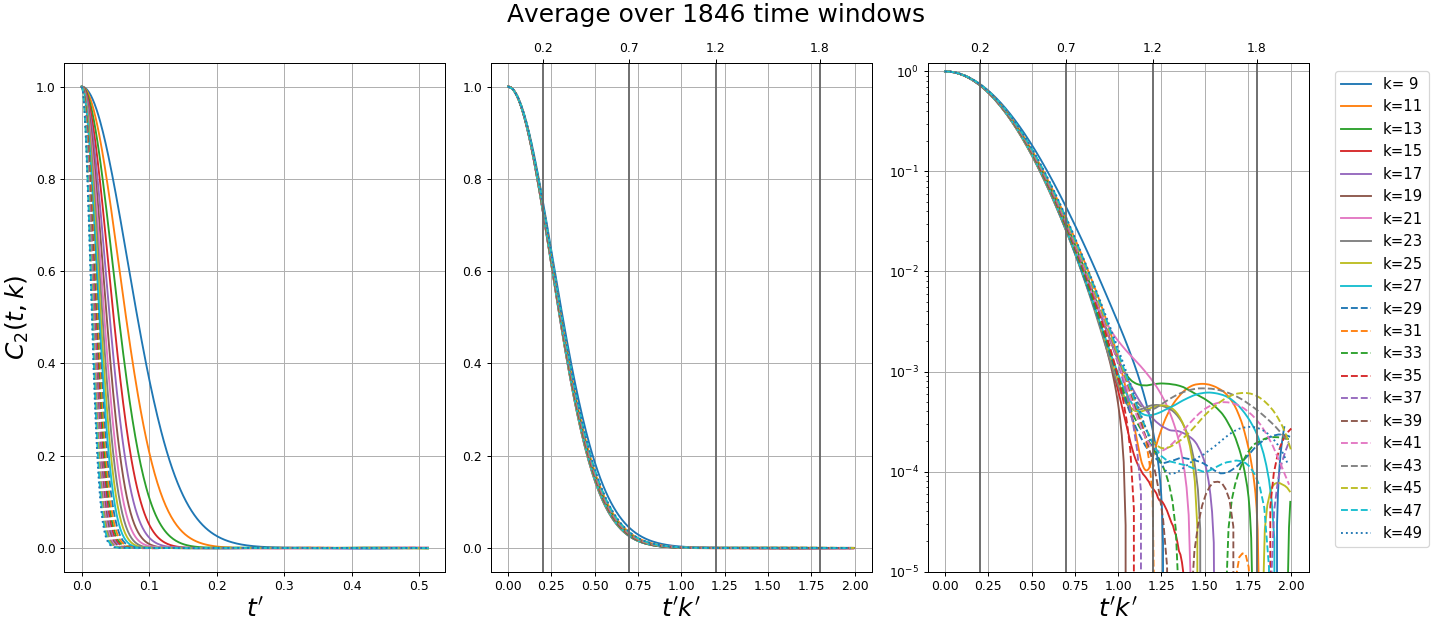

In [30]:
tk1 = 0.0
tk2 = 2.0
iw = -1

vertical_lines = [0.2, 0.7, 1.2, 1.8]

fig, (norm_scale, tk_scale, log_scale) = plt.subplots(nrows=1, ncols=3,figsize=(16,7), constrained_layout=True)
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t/t0*k[ik]/kL, tk1)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2)
    norm_scale.plot(t/t0, correlation_mean[:,ik,iw]*normalization[ik])
    tk_scale.plot(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik])
    log_scale.semilogy(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik], label='k=%2.0f' % (k[ik]))
norm_scale.set(ylabel=r'$C_2 (t,k)$', xlabel=r'$t^\prime$'); norm_scale.grid()
tk_scale.set(xlabel=r'$t^\prime k^\prime$'); tk_scale.grid()
log_scale.set(xlabel=r'$t^\prime k^\prime$', ylim=[10e-6, 1.2]); log_scale.grid()
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for line in vertical_lines : log_scale.axvline(x=line, ls='-', color='dimgray'); tk_scale.axvline(x=line, ls='-', color='dimgray')
ax2 = tk_scale.twiny(); ax2.set(xlim = tk_scale.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels(vertical_lines)
ax2 = log_scale.twiny(); ax2.set(xlim = log_scale.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels(vertical_lines)

fig.suptitle('Average over %4.0f time windows' % (curves.shape[0] + iw), size=20) 
plt.show()

<IPython.core.display.Javascript object>


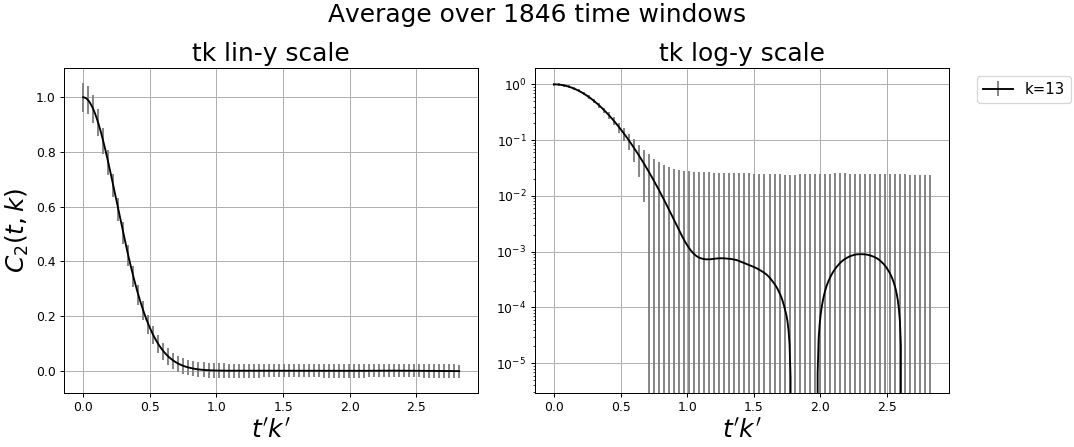

In [21]:
tk1 = 0.0
tk2 = 5.0
iw = -1
ik = 12

fig, (ax_lin, ax_log) = plt.subplots(nrows=1, ncols=2,figsize=(12,5), constrained_layout=True)
a = np.searchsorted(t/t0*k[ik]/kL, tk1)
b = np.searchsorted(t/t0*k[ik]/kL, tk2)
resample_every = 5

ybars = np.sqrt(np.abs(correlation_var[:,ik,iw]))*normalization[ik]
         
ax_lin.errorbar(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik], yerr=ybars[a:b], errorevery=resample_every, label='k=%2.f' % (k[ik]), color='black', ecolor='gray')
ax_log.errorbar(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik], yerr=ybars[a:b], errorevery=resample_every, label='k=%2.f' % (k[ik]), color='black', ecolor='gray')

ax_lin.set(title='tk lin-y scale', xlabel=r'$t^\prime k^\prime$', ylabel=r'$C_2 (t,k)$'); ax_lin.grid()
ax_log.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$'); ax_log.grid()
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_log.set_yscale("log", nonposy='clip')

fig.suptitle('Average over %4.0f time windows' % (curves.shape[0] + iw), size=20) 
plt.show()

In [31]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ik = 10
# Z = (correlation_mean*normalization)[:,11,:]
# X, Y = np.meshgrid(curves, t)
# ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# plt.show()

<IPython.core.display.Javascript object>


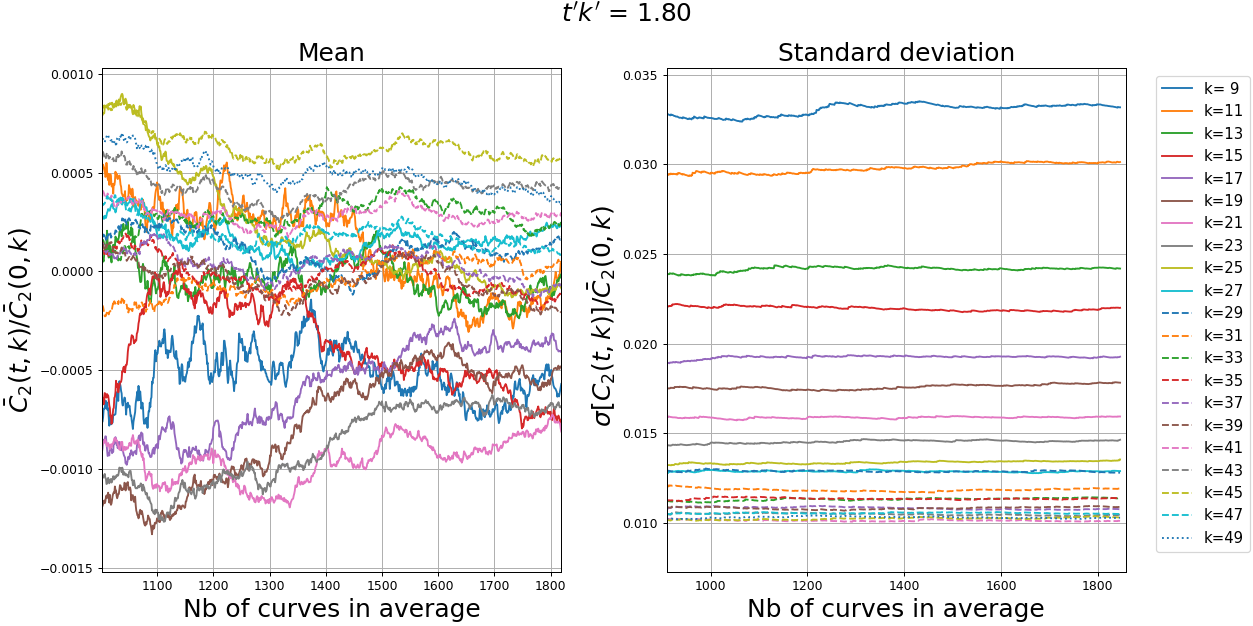

In [34]:
tk = 1.8

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(14,7))
x1 = 0
for ik in indices_of_k_to_plot :
    it = np.searchsorted(t/t0*k[ik]/kL, tk)
    axs[0].plot(curves[x1:], correlation_mean[it,ik,x1:]*normalization[ik])
    axs[1].plot(curves[x1:], np.sqrt(np.abs(correlation_var[it,ik,x1:]))*normalization[ik],label='k=%2.f' % (k[ik]))
axs[0].set(yscale='linear', xlabel='Nb of curves in average', ylabel=r'$\bar{C}_2 (t,k)  / \bar{C}_2(0,k) $', title='Mean'); axs[0].grid()
axs[1].set(yscale='linear', xlabel='Nb of curves in average', ylabel=r' $ \sigma [C_2(t, k)] / \bar{C}_2(0,k)$', title='Standard deviation'); axs[1].grid()
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle(r'$t^\prime k^\prime$ = %2.2f' % tk, size=20)
plt.show()

In [13]:
it

25